In [25]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [26]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install qiskit

Note: you may need to restart the kernel to use updated packages.


In [28]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [29]:
torch.cat((torch.Tensor([0.2]), 1 - torch.Tensor([0.2])), -1)

tensor([0.2000, 0.8000])

In [30]:
torch.cat((torch.Tensor([[0.2]]), 1 - torch.Tensor([[0.2]])), -1)

tensor([[0.2000, 0.8000]])

In [31]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        all_qubits = [i for i in range(n_qubits)]
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        
        self.theta = []
        for i in range(n_qubits):
            self.theta.append(qiskit.circuit.Parameter('theta' + str(i)))
            self._circuit.ry(self.theta[-1], i)
        
        self._circuit.measure_all()
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        #print('in the run')
        #print('theta = ', thetas)
        t_qc = transpile(self._circuit,
                         self.backend)
        dict_for_use = {}
        for i in range(len(self.theta)):
            dict_for_use[self.theta[i]] = thetas[i]
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [dict_for_use])
        
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        #print(result)
        collection = [0] * self.n_qubits
        #It means the probability of '1' for each qubit
        for str_ in list(result.keys()):
            for j in range(len(str_)):
                if int(str_[len(str_) - 1 - j]):
                    collection[j] += 1/self.shots * result[str_]
        
        #print('collection = ', collection)
        
        return collection

In [32]:
bool(int('0'))

False

In [33]:
a = torch.Tensor([1, 2, 3])
np.sum(np.array(a))

6.0

In [34]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(2, simulator, 100)
#print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

┌───┐ ░ ┌────────────┐ ░ ┌─┐   
   q_0: ┤ H ├─░─┤ Ry(theta0) ├─░─┤M├───
        ├───┤ ░ ├────────────┤ ░ └╥┘┌─┐
   q_1: ┤ H ├─░─┤ Ry(theta1) ├─░──╫─┤M├
        └───┘ ░ └────────────┘ ░  ║ └╥┘
meas: 2/══════════════════════════╩══╩═
                                  0  1

In [35]:
torch.tensor([[1, 2]])

tensor([[1, 2]])

In [36]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        #print(expectation_z)
        #here
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        #print('shift_right =', shift_right)
        #print('shift_left =', shift_left)
        #gradients = []
        #print('grad_output.float() = ', grad_output.float())
        
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = 0.5 * (torch.tensor([expectation_right]) - torch.tensor([expectation_left]))
            #print('gradient = ', gradient)
            gradients = gradient.numpy().T
            #gradients.append(gradient)
            #print('gradients = ', gradients)
            
        #gradients = np.array([gradients]).T
        
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, num, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(num, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [37]:
torch.Tensor([[0.4950, 0.2]]).numpy().T

array([[0.495],
       [0.2  ]], dtype=float32)

In [38]:
np.array([[torch.Tensor([[0.4950, 0.2]]).numpy() ]]).T

array([[[[0.495]]],


       [[[0.2  ]]]], dtype=float32)

In [39]:
np.array([[torch.Tensor([[0.4950]])]]).T

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.


array([[0.495]], dtype=float32)

In [40]:
print(torch.Tensor([5, 3, 2, 4, 1]))
np.where(torch.Tensor([5, 3, 2, 4, 1]) <= 3)

tensor([5., 3., 2., 4., 1.])


(array([1, 2, 4], dtype=int64),)

In [41]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

for i in range(2, 8):
    idx = np.append(idx, np.where(X_train.targets == i)[0][:n_samples])
    
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

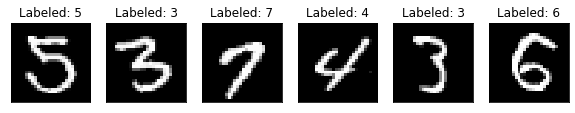

In [42]:
n_samples_show = 6

data_iter = iter(train_loader)

fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [43]:
axes[0]

In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 8)
        self.hybrid = Hybrid(8, qiskit.Aer.get_backend('aer_simulator'), 200, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #print('input = ', x)
        x = self.hybrid(x)
        x = F.softmax(x)
        #print('x = ', x)
        return x

In [45]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()
#loss_func = nn.CrossEntropyLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        #print(target == 7)
        #print(target.numpy()[0] == 7)
        '''
        if target.numpy()[0] == 7:
            target = torch.LongTensor([0])
            '''
        optimizer.zero_grad()
        # Forward pass
        #print(data.size())
        output = model(data)
        # Calculating loss
        #print('output = ', output)
        #print('target = ', target)
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training [5%]	Loss: -0.1271
Training [10%]	Loss: -0.1232
Training [15%]	Loss: -0.1257
Training [20%]	Loss: -0.1293
Training [25%]	Loss: -0.1286
Training [30%]	Loss: -0.1272
Training [35%]	Loss: -0.1237
Training [40%]	Loss: -0.1273
Training [45%]	Loss: -0.1274
Training [50%]	Loss: -0.1246
Training [55%]	Loss: -0.1269
Training [60%]	Loss: -0.1239
Training [65%]	Loss: -0.1249
Training [70%]	Loss: -0.1247
Training [75%]	Loss: -0.1247
Training [80%]	Loss: -0.1269
Training [85%]	Loss: -0.1266
Training [90%]	Loss: -0.1264
Training [95%]	Loss: -0.1259
Training [100%]	Loss: -0.1266


Text(0, 0.5, 'Neg Log Likelihood Loss')

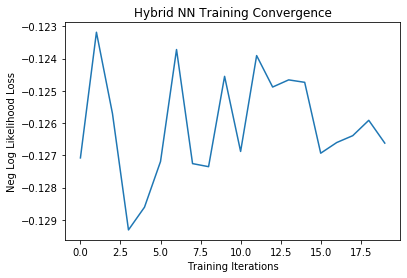

In [46]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [47]:
# Concentrating on the first 100 samples
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

for i in range(2, 8):
    idx = np.append(idx, np.where(X_test.targets == i)[0][:n_samples])
    
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]
#print(X_test.targets)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [49]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        '''
        if target.numpy()[0] == 7:
            target = torch.LongTensor([0])
        '''
        pred = output.argmax(dim=1, keepdim=True)
        #print(pred)
        #print(pred.eq(target.view_as(pred)).sum().item())
        correct += pred.eq(target.view_as(pred)).sum().item()
        #print(output, target)
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Performance on test data:
	Loss: -0.1271
	Accuracy: 14.5%
